## Logistic Regression with Tensorflow
This notebook will focus on going through the mechanics of setting up a logistic regression machine learning model with the Tensorflow framework.

In [1]:
# Import necessary packages
import numpy as np
import pandas as pd
import pandas_profiling

import seaborn as sns
sns.set(style='whitegrid')
import matplotlib.pyplot as plt
import sys

import tensorflow as tf

### Read data
In this example we will use the Iris dataset. Using Pandas Profiling we can check the basic characteristics of the dataset.

In [2]:
df = pd.read_csv('../data/Iris.csv')

In [3]:
#pandas_profiling.ProfileReport(df)

In [3]:
# Or the classic way:
print(df.shape)
df.head()

(150, 6)


,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
# Unique classes in the dataset
list(df.Species.unique())

['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']

In [5]:
%matplotlib inline

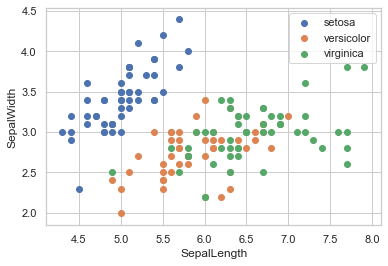

In [6]:
plt.scatter(df[df['Species']=='Iris-setosa'].SepalLengthCm, df[df['Species']=='Iris-setosa'].SepalWidthCm, label='setosa')
plt.scatter(df[df['Species']=='Iris-versicolor'].SepalLengthCm, df[df['Species']=='Iris-versicolor'].SepalWidthCm, label='versicolor')
plt.scatter(df[df['Species']=='Iris-virginica'].SepalLengthCm, df[df['Species']=='Iris-virginica'].SepalWidthCm, label='virginica')
plt.xlabel('SepalLength')
plt.ylabel('SepalWidth')
plt.legend(loc='best')
plt.show();

Let's create a model that can predict if the species is Iris-setosa.<br>To do that, we need to recode the variable Species.

In [7]:
df['Species'] = np.where(df['Species'] == 'Iris-setosa', 1, 0)

In [8]:
print(df.shape)
df.head()

(150, 6)


,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,1
1,2,4.9,3.0,1.4,0.2,1
2,3,4.7,3.2,1.3,0.2,1
3,4,4.6,3.1,1.5,0.2,1
4,5,5.0,3.6,1.4,0.2,1


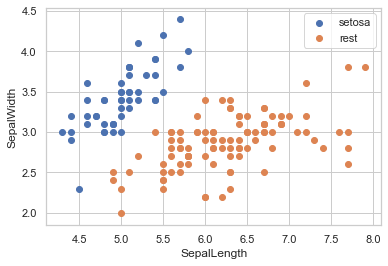

In [9]:
plt.scatter(df[df['Species']==1].SepalLengthCm, df[df['Species']==1].SepalWidthCm, label='setosa')
plt.scatter(df[df['Species']==0].SepalLengthCm, df[df['Species']==0].SepalWidthCm, label='rest')
plt.xlabel('SepalLength')
plt.ylabel('SepalWidth')
plt.legend(loc='best')
plt.show();

### Data prep

In [10]:
# Create X and y-variables for prediction
X = df.drop(labels=['Id', 'Species'], axis=1).values
y = df['Species'].values

In [11]:
# Set seed for tf
tf.set_random_seed(101)

In [12]:
# Create train and test split (60/40)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)

In [13]:
# Define the normalized function
def min_max_normalized(data):
    col_max = np.max(data, axis=0)
    col_min = np.min(data, axis=0)
    return np.divide(data - col_min, col_max - col_min)

In [14]:
# Normalize dataset
X_train = min_max_normalized(X_train)
X_test = min_max_normalized(X_test)

### Define the model

In [15]:
# Declare the variables that need to be learned and initialization
A = tf.Variable(tf.random_normal(shape=[4, 1]))
b = tf.Variable(tf.random_normal(shape=[1, 1]))

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

Instructions for updating:
Colocations handled automatically by placer.


In [16]:
# Define data and target variables
data = tf.placeholder(dtype=tf.float32, shape=[None, 4])
target = tf.placeholder(dtype=tf.float32, shape=[None, 1])

In [17]:
# Declare the model you need to learn
mod = tf.matmul(data, A) + b

In [18]:
# Declare loss function (sigmoid cross-entropy)
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=mod, labels=target))

In [19]:
# Define the learning rate， batch_size and number of epochs
learning_rate = 0.01
batch_size = 30
iter_num = 1500

In [20]:
# Define the optimizer
opt = tf.train.GradientDescentOptimizer(learning_rate)

In [21]:
# Define the goal
goal = opt.minimize(loss)

In [22]:
# Define the accuracy
prediction = tf.round(tf.sigmoid(mod))
correct = tf.cast(tf.equal(prediction, target), dtype=tf.float32)
accuracy = tf.reduce_mean(correct)

### Train the model

In [23]:
loss_trace = []
train_acc = []
test_acc = []

In [24]:
# training model
for epoch in range(iter_num):
    # Generate random batch index
    batch_index = np.random.choice(len(X_train), size=batch_size)
    batch_X_train = X_train[batch_index]
    batch_y_train = np.matrix(y_train[batch_index]).T
    sess.run(goal, feed_dict={data: batch_X_train, target: batch_y_train})
    temp_loss = sess.run(loss, feed_dict={data: batch_X_train, target: batch_y_train})
    
    # convert into a matrix, and the shape of the placeholder to correspond
    temp_train_acc = sess.run(accuracy, feed_dict={data: X_train, target: np.matrix(y_train).T})
    temp_test_acc = sess.run(accuracy, feed_dict={data: X_test, target: np.matrix(y_test).T})
    
    # recode the result
    loss_trace.append(temp_loss)
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    
    # output
    if (epoch + 1) % 300 == 0:
        print('epoch: {:4d} loss: {:5f} train_acc: {:5f} test_acc: {:5f}'.format(epoch + 1, temp_loss,
                                                                          temp_train_acc, temp_test_acc))

epoch:  300 loss: 0.698053 train_acc: 0.511111 test_acc: 0.600000
epoch:  600 loss: 0.557946 train_acc: 0.688889 test_acc: 0.750000
epoch:  900 loss: 0.380182 train_acc: 0.744444 test_acc: 0.800000
epoch: 1200 loss: 0.339388 train_acc: 0.900000 test_acc: 0.833333
epoch: 1500 loss: 0.284412 train_acc: 0.977778 test_acc: 0.933333


### Visualize the model


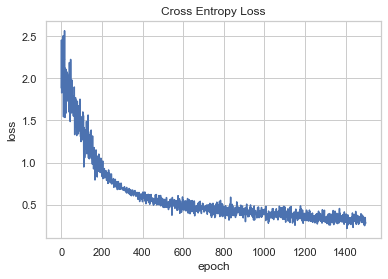

In [25]:
# loss function
plt.plot(loss_trace)
plt.title('Cross Entropy Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

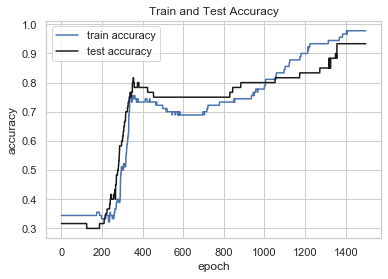

In [26]:
# accuracy
plt.plot(train_acc, 'b-', label='train accuracy')
plt.plot(test_acc, 'k-', label='test accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Train and Test Accuracy')
plt.legend(loc='best')
plt.show()

As you can see we got some good results for an initial model, the minimum accuracy landed at 0.93 for the test set after 1500 epochs which is really good. But the main goal was to see if we could design a logistic regression model using Tensorflow instead of scikit-learn which we did.

